In [1]:
#Imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import random
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, hstack
from scipy.optimize import curve_fit
from sympy import *
import math
from mpmath import *
from pandas.compat import StringIO
from numpy.linalg import inv
from scipy import linalg
from scipy import interpolate
from scipy import integrate
from scipy.integrate import quad
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree
import scipy.spatial as spatial

## Import data

In [2]:
#The COSMOS 30-band data matched to some of the HSC data in the COSMOS field
cosmos_matched_path= '../../../cosmos_matched_hsc.fits'
hdulist = fits.open(cosmos_matched_path)
cosmos_matched_data = hdulist[1].data
cosmos_matched_columns= hdulist[1].columns

#All the HSC data in COSMOS field
hsc_cosmos_path= '/global/cscratch1/sd/damonge/HSC/HSC_processed/DEEP_COSMOS/DEEP_COSMOS_Catalog_i24.50.fits'
hdulist = fits.open(hsc_cosmos_path)
hsc_cosmos_data = hdulist[1].data
hsc_cosmos_columns= hdulist[1].columns

## Cut HSC galaxies into redshift bins based on ephor ab z_best

In [3]:
def make_samples(cosmos_matched_data):
    cosmos_matched_df= pd.DataFrame(cosmos_matched_data)

    #Training set, or HSC photometry that matches to COSMOS 30-band
    Train_sample= np.zeros([len(cosmos_matched_df),5])
    for i in range(len(cosmos_matched_df)):
        Train_sample[i]= np.array([cosmos_matched_df.iloc[i,536:541]]) #These are the magnitude values
        
    #COSMOS 30-band photometric redshifts
    Train_z = np.array(cosmos_matched_df['PHOTOZ'])
    
    return Train_sample, Train_z

In [4]:
def make_binned_samples(hsc_cosmos_data):
    hsc_cosmos_df= pd.DataFrame(hsc_cosmos_data)
    
    Photoz_sample= np.zeros([len(hsc_cosmos_df),5])
    for i in range(len(hsc_cosmos_df)):
        Photoz_sample[i]= np.array([hsc_cosmos_df.iloc[i,88:93]]) #These are the magnitude values
        
    return Photoz_sample

In [7]:
def form_z_bins(hsc_cosmos_data):
    hsc_cosmos_bin1= hsc_cosmos_data[(hsc_cosmos_data['pz_best_eab']>0.15) & (hsc_cosmos_data['pz_best_eab']<=0.5)]
    hsc_cosmos_bin2= hsc_cosmos_data[(hsc_cosmos_data['pz_best_eab']>0.5) & (hsc_cosmos_data['pz_best_eab']<=0.75)]
    hsc_cosmos_bin3= hsc_cosmos_data[(hsc_cosmos_data['pz_best_eab']>0.75) & (hsc_cosmos_data['pz_best_eab']<=1.0)]
    hsc_cosmos_bin4= hsc_cosmos_data[(hsc_cosmos_data['pz_best_eab']>1.0) & (hsc_cosmos_data['pz_best_eab']<=1.5)]
    
    return hsc_cosmos_bin1, hsc_cosmos_bin2, hsc_cosmos_bin3, hsc_cosmos_bin4

In [8]:
hsc_cosmos_bin1, hsc_cosmos_bin2, hsc_cosmos_bin3, hsc_cosmos_bin4 = form_z_bins(hsc_cosmos_data)

In [10]:
Train_sample, Train_z = make_samples(cosmos_matched_data)
Photoz_bin1= make_binned_samples(hsc_cosmos_bin1)
Photoz_bin2= make_binned_samples(hsc_cosmos_bin2)
Photoz_bin3= make_binned_samples(hsc_cosmos_bin3)
Photoz_bin4= make_binned_samples(hsc_cosmos_bin4)

In [11]:
#Input the total number of training galaxies
N_train_tot= len(Train_sample)

#Input the total number of photometric galaxies
N_photo_tot_bin1= len(Photoz_bin1)
N_photo_tot_bin2= len(Photoz_bin2)
N_photo_tot_bin3= len(Photoz_bin3)
N_photo_tot_bin4= len(Photoz_bin4)

#Define the fixed N_nei that I want to use 
N_nei = 20

#Input redshift bin info - weights will be summed in each redshift bin
num_bin= 150
bins= np.linspace(0, 6.0, num=150, endpoint=False)
bins=np.append(bins,6)

## Get the nearest neighbours

In [12]:
def find_nn(N_nei, Train_sample):
    #Find the nearest neigbours for each of the training galaxies 
    N_nbrs = NearestNeighbors(n_neighbors=N_nei, algorithm='kd_tree', metric='euclidean').fit(Train_sample)

    #Get the distances to each of the neighbours
    distances, indices = N_nbrs.kneighbors(Train_sample)
    return distances, indices

In [13]:
distances, indices = find_nn(N_nei, Train_sample)

### Extract the distance to the furthest k-nearest neighbour

In [14]:
def furthest_dist(Train_sample, distances):
    d_dist= np.zeros(len(Train_sample))
    #Make an array with the distances to the furthest neighbour for each training galaxy
    for i in range(len(Train_sample)):
        d_dist[i] = distances[i][len(distances[0])-1]
    return d_dist

In [15]:
d_dist = furthest_dist(Train_sample, distances)

### Find the number of photo-z galaxies within the furthest distance (d_dist) from each spec-z galaxy

In [16]:
def photoz_within_dist(Photoz_sample, Train_sample, d_dist):
    #Make the spatial.cKDTree object
    tree_NN_lookup = spatial.cKDTree(Photoz_sample, leafsize=40)

    #Make a corresponding array of the number of photo-z galaxies in the same area as N_nei training gals, for each train gal 
    num_photoz= np.zeros(len(Train_sample))

    #Query the indicies of the points that lie within a distance of the point given 
    for i in range(len(Train_sample)):
        num_photoz[i]= len(tree_NN_lookup.query_ball_point(Train_sample[i], d_dist[i]+0.00000100))
        
    return num_photoz

In [17]:
num_photoz_bin1= photoz_within_dist(Photoz_bin1, Train_sample, d_dist)
num_photoz_bin2= photoz_within_dist(Photoz_bin2, Train_sample, d_dist)
num_photoz_bin3= photoz_within_dist(Photoz_bin3, Train_sample, d_dist)
num_photoz_bin4= photoz_within_dist(Photoz_bin4, Train_sample, d_dist)

In [18]:
def make_weights(Train_sample, num_photoz, N_nei, N_photo_tot):
    
    #Make a corresponding array of the weights for each of the training galaxies
    weights= np.zeros(len(Train_sample))

    #Make the weights
    weights = np.true_divide(num_photoz,N_nei*N_photo_tot)
    return weights

In [19]:
weights_bin1 = make_weights(Train_sample,num_photoz_bin1, N_nei, N_photo_tot_bin1)
weights_tot_bin1= np.sum(weights_bin1)  #Sum weights over all training galaxies

weights_bin2 = make_weights(Train_sample,num_photoz_bin2, N_nei, N_photo_tot_bin2)
weights_tot_bin2= np.sum(weights_bin2)  

weights_bin3 = make_weights(Train_sample,num_photoz_bin3, N_nei, N_photo_tot_bin3)
weights_tot_bin3= np.sum(weights_bin3) 

weights_bin4 = make_weights(Train_sample,num_photoz_bin4, N_nei, N_photo_tot_bin4)
weights_tot_bin4= np.sum(weights_bin4) 

In [20]:
def weights_per_bin(num_bin, Train_sample, Train_z, bins, weights):
    
    #Weights per redshift bin  
    weights_bin= np.zeros(num_bin)

    for j in range(num_bin):
        for i in range(len(Train_sample)):
            if Train_z[i]>bins[j] and Train_z[i]<=bins[j+1]:
                weights_bin[j]+=weights[i]
                
    return weights_bin

In [21]:
weights_per_bin_bin1= weights_per_bin(num_bin, Train_sample, Train_z, bins,weights_bin1)
weights_per_bin_bin2= weights_per_bin(num_bin, Train_sample, Train_z, bins,weights_bin2)
weights_per_bin_bin3= weights_per_bin(num_bin, Train_sample, Train_z, bins,weights_bin3)
weights_per_bin_bin4= weights_per_bin(num_bin, Train_sample, Train_z, bins,weights_bin4)

## Find the estimated photo-z N(z)

In [22]:
def Nz(weights_per_bin, weights_tot, N_photo_tot):
    P_T_z_delta_z =  np.true_divide(weights_per_bin, weights_tot)
    N_p_est = P_T_z_delta_z*N_photo_tot
    return N_p_est

In [23]:
N_p_est_bin1= Nz(weights_per_bin_bin1, weights_tot_bin1, N_photo_tot_bin1)
N_p_est_bin2= Nz(weights_per_bin_bin2, weights_tot_bin2, N_photo_tot_bin2)
N_p_est_bin3= Nz(weights_per_bin_bin3, weights_tot_bin3, N_photo_tot_bin3)
N_p_est_bin4= Nz(weights_per_bin_bin4, weights_tot_bin4, N_photo_tot_bin4)

## Plot N(z) in each redshift bin

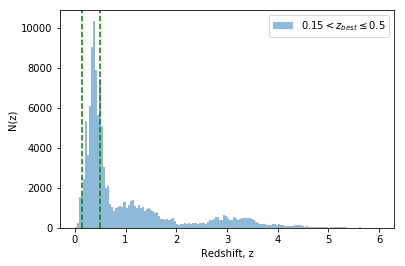

In [24]:
#Bin 1
plt.bar(bins[:-1],N_p_est_bin1, width= 0.04, align='edge', alpha=0.5, label= '$0.15< z_{best}\leq 0.5$')
plt.xlabel('Redshift, z')
plt.ylabel('N(z)')

plt.axvline(x=0.15, ls='dashed', color='g')
plt.axvline(x=0.5, ls='dashed', color='g')

plt.legend()

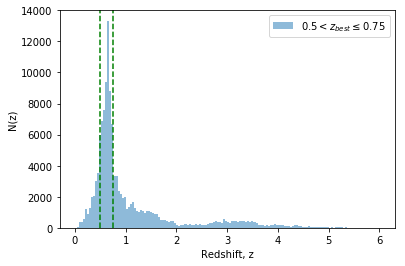

In [25]:
#Bin 2
plt.bar(bins[:-1],N_p_est_bin2, width= 0.04, align='edge',alpha=0.5,label= '$0.5< z_{best}\leq 0.75$')
plt.xlabel('Redshift, z')
plt.ylabel('N(z)')

plt.axvline(x=0.5, ls='dashed', color='g')
plt.axvline(x=0.75, ls='dashed', color='g')
plt.legend()

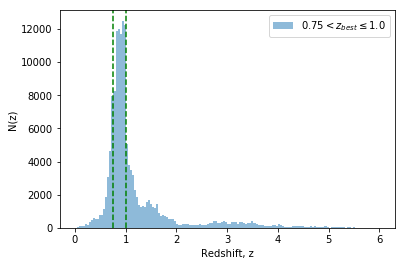

In [26]:
#Bin 3
plt.bar(bins[:-1],N_p_est_bin3, width= 0.04, align='edge',alpha=0.5,label='$0.75< z_{best}\leq 1.0$')
plt.xlabel('Redshift, z')
plt.ylabel('N(z)')

plt.axvline(x=0.75, ls='dashed', color='g')
plt.axvline(x=1.0, ls='dashed', color='g')
plt.legend()

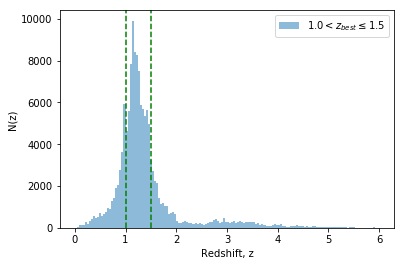

In [27]:
#Bin 4
plt.bar(bins[:-1],N_p_est_bin4, width= 0.04, align='edge',alpha=0.5,label='$1.0< z_{best}\leq 1.5$' )
plt.xlabel('Redshift, z')
plt.ylabel('N(z)')

plt.axvline(x=1.0, ls='dashed', color='g')
plt.axvline(x=1.5, ls='dashed', color='g')
plt.legend()

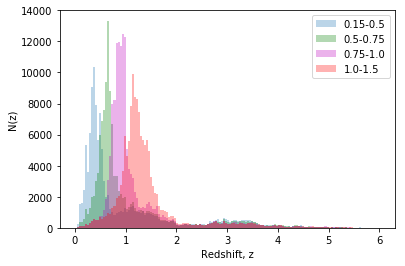

In [28]:
plt.bar(bins[:-1],N_p_est_bin1, width= 0.04,align='edge', alpha=0.3, label='0.15-0.5')

plt.bar(bins[:-1],N_p_est_bin2, width= 0.04, color= 'g',align='edge',alpha=0.3, label= '0.5-0.75')

plt.bar(bins[:-1],N_p_est_bin3, width= 0.04, color= 'm', align='edge',alpha=0.3,label= '0.75-1.0')

plt.bar(bins[:-1],N_p_est_bin4, width= 0.04, color='r', align='edge',alpha=0.3,label= '1.0-1.5')
plt.xlabel('Redshift, z')
plt.ylabel('N(z)')

plt.legend()